In [1]:
import numpy as np
import datetime

import matplotlib.pyplot as plt
from PIL import Image

from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans,spectral_clustering
from numpy.linalg import norm
from sklearn.feature_extraction import image

import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_A_B_and_weight_vec(n_nodes,threshold,sigma=1):
    '''
    Generate graph structure from the image to be segmented.
    Inputs:
        n_nodes: number of nodes, i.e. number of pixels
        threshold: threshold to drop edges with small weights (weak similarities)
        sigma: parameter to scale edge weights
    Outputs:
        B: Incidence matrix
        Weight_vec: edge_wise weights
    '''
    N = n_nodes
    A = np.zeros((N,N))
    row = []
    col = []
    data = []
    weight_vec = []
    cnt = 0
    img_w = 100
    for i in range(N):
        for j in [i+1,i+2,i+img_w,i+img_w*2,i+(img_w-1),i+(img_w-1)*2,i+(img_w+1),i+(img_w+1)*2]:
            if j>N-1:
                continue
            elif np.exp(-norm(img[i]-img[j])/(2*sigma**2)) > threshold:
                row.append(cnt)
                col.append(i)
                data.append(1)

                row.append(cnt)
                col.append(j)
                data.append(-1)
                cnt += 1
                weight_vec.append(np.exp(-norm(img[i]-img[j])/(2*sigma**2)))
                A[i,j] = np.exp(-norm(img[i]-img[j])/(2*sigma**2))
                A[j,i] = np.exp(-norm(img[i]-img[j])/(2*sigma**2))

    B = csr_matrix((data, (row, col)), shape=(cnt, N))
#     A = csr_matrix(A)
    weight_vec = np.array(weight_vec)
    return B, weight_vec,A

In [3]:
def algorithm(B, weight_vec, seeds,K=15000,alpha=0.02, lambda_nLasso=None, check_s=False):
    E, N = B.shape
#     weight_vec = np.ones(E)

    Gamma_vec = np.array(1./(np.sum(abs(B), 0)))[0]  # \in [0, 1]
    Gamma = np.diag(Gamma_vec)

    Sigma = 0.5

    seednodesindicator= np.zeros(N)
    seednodesindicator[seeds] = 1        


    
    noseednodeindicator = np.ones(N)
    noseednodeindicator[seeds] = 0
    
    if lambda_nLasso == None:
        lambda_nLasso = 2 / math.sqrt(np.sum(weight_vec))
    
    if check_s:
        s = 0.0
        for item in range(len(weight_vec)):
            x = B[item].toarray()[0]
            i = np.where(x == -1)[0][0]
            j = np.where(x == 1)[0][0]
            if i < N1 <= j:
                s += weight_vec[item]
            elif i >= N1 > j:
                s += weight_vec[item]

        if lambda_nLasso * s >= alpha * N2 / 2:
            print ('eq(24)', lambda_nLasso * s, alpha * N2 / 2)
    
    fac_alpha = 1./(Gamma_vec*alpha+1)  # \in [0, 1]

    hatx = np.zeros(N)
    newx = np.zeros(N)
    prevx = np.zeros(N)
    haty = np.array([x/(E-1) for x in range(0, E)])
    history = []
    for iterk in range(K):
        # if 0 < np.max(abs(newx - prevx)) < 1e-4:
        #     print(iterk)
        #     break
        tildex = 2 * hatx - prevx
        newy = haty + Sigma * B.dot(tildex)  # chould be negative
        haty = newy / np.maximum(abs(newy) / (lambda_nLasso * weight_vec), np.ones(E))  # could be negative

        newx = hatx - Gamma_vec * B.T.dot(haty)  # could  be negative
        newx[seeds] = (newx[seeds] + Gamma_vec[seeds]) / (1 + Gamma_vec[seeds])

        newx = seednodesindicator * newx + noseednodeindicator * (newx * fac_alpha)
        prevx = np.copy(hatx)
        hatx = newx  # could be negative
        history.append(newx)
    
    history = np.array(history)

    return history
    
    

In [4]:
img=Image.open("bears.jpg")
# img=img.convert('L')

In [5]:
basewidth = 100
wpercent = (basewidth / float(img.size[0]))
hsize = int((float(img.size[1]) * float(wpercent)))
img = img.resize((basewidth, hsize), Image.ANTIALIAS)
img = np.array(img)
print(img.shape)

(56, 100, 3)


In [6]:
from skimage.data import coins

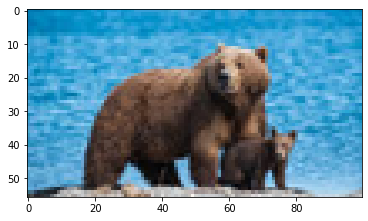

In [7]:
plt.imshow(img)

# Segment the image via our method

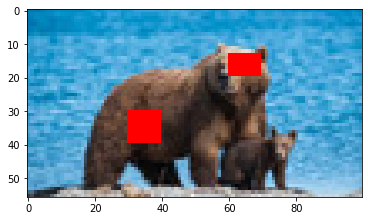

In [8]:
img_seeds = np.copy(img)
img_seeds[30:40,30:40]=[255,0,0]
img_seeds[13:20,60:70]=[255,0,0]
# img_seeds[120:140,190:210]=[255,0,0]
# img_seeds[100:120,130:150]=[255,0,0]
# img_seeds[120:130,220:230]=[255,0,0]
plt.imshow(img_seeds)
# plt.savefig('bears_seeds.jpg')

In [9]:
seeds = []
for i in range(img.shape[0]*img.shape[1]):
    if (img_seeds.reshape(-1,3)[i]==[255,0,0]).all():
        seeds.append(i)
print('number of seeds:',len(seeds))    

number of seeds: 170


In [10]:
img = img.reshape(-1,3)/255
n_nodes=img.shape[0]
print("number of nodes:",n_nodes )

number of nodes: 5600


In [11]:
# B,weight,A =get_A_B_and_weight_vec(n_nodes,0,1)
# plt.hist(weight,bins=30)  #distribution of similarity measure

In [12]:
def run_seg(n_nodes,seeds,threshold, K=30, alpha=0.1, lambda_nLasso=0.1):
    B, weight_vec,A = get_A_B_and_weight_vec(n_nodes,threshold)
    
    start = datetime.datetime.now()
    history = algorithm(B, weight_vec, seeds=seeds, K=K, alpha=alpha, lambda_nLasso=lambda_nLasso)
    print('our method time: ', datetime.datetime.now() - start)    
    return history

our method time:  0:00:05.378841


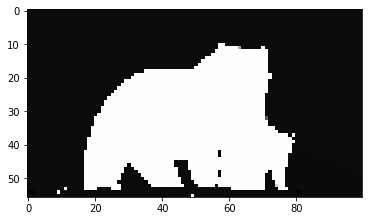

In [13]:
history = run_seg(n_nodes=n_nodes,seeds=seeds,threshold = 0.90, K=3000,alpha=0.001, lambda_nLasso=0.05)
plt.imshow(history[-1].reshape(56,100),cmap="gray")

# plt.savefig('learned_bears.jpg')

(array([3.678e+03, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.919e+03]),
 array([-4.70044695e-19,  9.96346729e-02,  1.99269346e-01,  2.98904019e-01,
         3.98538691e-01,  4.98173364e-01,  5.97808037e-01,  6.97442710e-01,
         7.97077383e-01,  8.96712056e-01,  9.96346729e-01]),
 <a list of 10 Patch objects>)

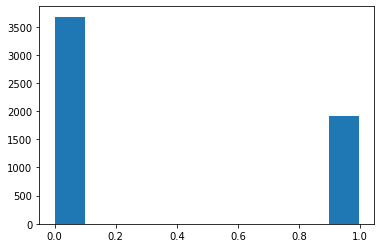

In [14]:
X = np.nan_to_num(history[-1])
plt.hist(X)

In [15]:
# Run k-means to cluster node signals into 2 clusters
kmeans = KMeans(n_clusters=2).fit(np.nan_to_num(X).reshape(len(history[-1]), 1))

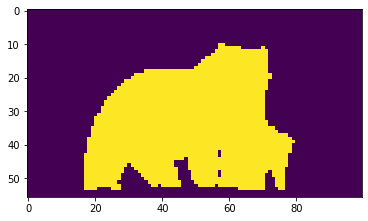

In [16]:
segmented = kmeans.labels_
plt.imshow(segmented.reshape((56,100)))  # run 20 iterations

# plt.savefig('bears_seg.jpg')

# Run KMeans alone to perform clustering

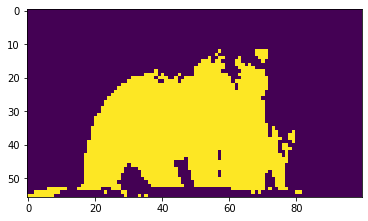

In [17]:
k = KMeans(2).fit(img)
plt.imshow(k.labels_.reshape(56,100))

# Run spectral clustering to perform clustering

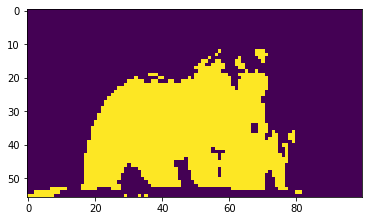

In [18]:
from sklearn.cluster import SpectralClustering

s=SpectralClustering(2).fit(img)

plt.imshow(s.labels_.reshape(56,100))

In [19]:
# img=Image.open("bears.jpg")
# plt.imshow(img)
# for l in range(2):
#     plt.contour(segmented.reshape((168,299)) == l,
#                 colors=[plt.cm.nipy_spectral((l) / float(2)), ])
# # plt.gca().invert_yaxis()
# # plt.savefig('bears_contour.jpg')
# plt.show()
# # plt.savefig('bears_contour.jpg')